## Machine Learning HackPack

### Purpose of this HackPack

This guide aims to provide beginners with practical steps to create machine learning models using popular libraries like TensorFlow and PyTorch. It focuses on hands-on expereince without diving deeply into theoretical concepts.

For more about the underlying theory, visit the resources at the bottom of this hackpack (or in the HackPack description document).

We're going to build a **DurHack Dino vs Barney classifier**!!

To open this notebook in CoLab head here:
<a target="_blank" href="https://colab.research.google.com/github/KaalkidanSahele/ML-HackPack/blob/main/Machine_Learning_HackPack.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
!pip install tensorflow keras matplotlib numpy opencv-python

Note that this may take a while - if there are any incomptabilities (like there was above), Python will try and resolve these for you

### Installations

We begun by installing the necessary libraries for this project. The key tools include:

- **NumPy** for numerical operations (https://numpy.org/)
- **OpenCV** for image manipulation (https://opencv.org/)
- **TensorFlow** for building neural networks (https://www.tensorflow.org/guide)
- **Keras** for data augmentation (https://www.tensorflow.org/guide/keras)

Note: if you encounter warnings about floating-point round-off errors or missing GPU drivers, don't worry! Tese warning are typical in machine learning tasks and won't affect the main functionality of the project. 


In [2]:
## Pre-Processing Imports

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import os
import cv2
from tqdm import tqdm
import random

## TensorFlow imports
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator

from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
import pickle
import time

2024-10-30 17:03:56.595716: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-30 17:03:56.598151: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-30 17:03:56.648261: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-30 17:03:56.649626: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-30 17:03:58.028662: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Define your categories here for the images you want to classify. 
In this hackpack, we're differentiating between two variants of a purple dinosaur - **Barney**, and **the DurHack Dino**.

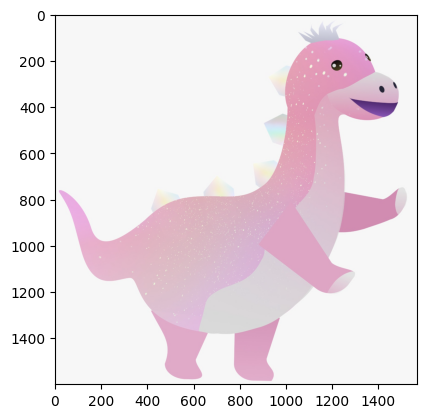

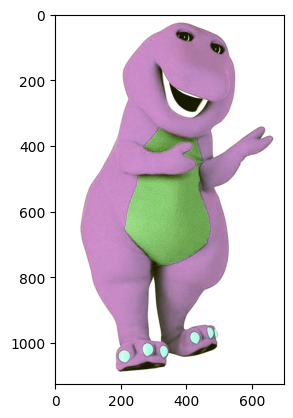

In [3]:
classes = ["dino", "barney"]
data_directory = 'data'
img_size = 150  # Resize images to uniform size for model input

def load_and_show_image(dino_barney_class, img_path):    
    img_array = cv2.imread(img_path) 
    plt.imshow(img_array)  # visualise the images so we can see if it's all right!
    plt.show()

def process_class_images(dino_barney_class):
    category_path = os.path.join(data_directory, dino_barney_class)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        load_and_show_image(dino_barney_class, img_path)
        break  
        #we break here because we only want to see one image of each class

def visualize_images():
    for dino_barney_class in classes:
        process_class_images(dino_barney_class)

# call the visualization function
visualize_images()

### Data Augmentation

Data augmentation is a technique used to artifically expand the size of a dataset by applying transformations (such as rotations, flips, or zooms). This helps prevent overfitting by allowing the model to generalise better. 

Here, we're going to augment our data! 

**Dino Data Augmentation:**

In [4]:
data_directory = 'data'
max_augmentations = 750

def augment_image(image_path, datagen, save_dir, prefix, max_augmentations):
    img = load_img(image_path)  # Load image
    data = img_to_array(img)  # Convert to array
    samples = expand_dims(data, 0)  # Expand dimensions
    it = datagen.flow(samples, batch_size=1, save_to_dir=save_dir, save_prefix=prefix, save_format='jpg')

    # generate and save augmented images
    for i, batch in enumerate(it):
        if i >= max_augmentations:
            break
            
## now we use the function we just defined to augment all our images and make our dataset!

def augment_images_in_category(category, datadir, augmented_dir, img_extension , max_augmentations):
    image_dir = os.path.join(datadir, category)
    my_images = os.listdir(image_dir)

    datagen = ImageDataGenerator(rotation_range=90, horizontal_flip=True)  # Create the data generator

    for image_name in my_images:
        if image_name.endswith(f'.{img_extension}'):  # check for correct file extension
            image_path = os.path.join(image_dir, image_name)
            augment_image(image_path, datagen, augmented_dir, prefix='dr', max_augmentations=max_augmentations)


**Dino & Barney data augmentation**

Awesome! We've defined what we want our augmentation to do. Let's run it on our original dino and Barney images. (This part my take a while)

In [5]:
from tqdm import tqdm

# dino data augmentation
augmented_data_directory = 'augmented_data/dino'
img_extension = 'jpg'  # if your images are PNGs, put png here!!

# just wrapping the function call in a tqdm loop to display progress
for _ in tqdm(range(max_augmentations), desc="Augmenting Dino Images"):
    augment_images_in_category("dino", data_directory, augmented_data_directory, img_extension, 1)

# barney data augmentation
augmented_data_directory_2 = 'augmented_data/barney'
img_extension = 'png'

for _ in tqdm(range(max_augmentations), desc="Augmenting Barney Images"):
    augment_images_in_category("barney", data_directory, augmented_data_directory_2, img_extension, 1)


Augmenting Barney Images: 100%|██████████| 750/750 [04:39<00:00,  2.68it/s]


### Data Pre-processing

Data preprocessing ensures that the input data is correctly formatted for model training. This step includes resizing images and converting them into arrays for easier manipulation by the model.

The following code processess both categories (dino and barney), resizes the images, and assigns each image a class label, **where 0 is for dino, and 1 for arney**.

We also **shuffle** the data to ensure that the model doesn't see all images from one class at once, which could bias training.

In [9]:
data_directory = "augmented_data"
training_data = []

#read and resize images to specified size for uniformity
def process_image(image_path, img_size):
    try:
        img_array = cv2.imread(image_path, cv2.IMREAD_COLOR)  
        resized_array = cv2.resize(img_array, (img_size, img_size))  
        return resized_array
    except Exception as e:
        print(f"Error processing {image_path}: {e}")  # Handle errors
        return None

#process images in given cateogry and append to training data
def process_category(category, datadir, img_size):
    path = os.path.join(datadir, category)  # path to category folder
    class_num = classes.index(category)  # class index for the category
    print(f"Processing category: {category}, class num: {class_num}")

    category_data = []
    for img in tqdm(os.listdir(path)):  # iterate through images in the category
        img_path = os.path.join(path, img)
        
        # skip non-image files or hidden directories like .ipynb_checkpoints
        if not img.endswith(('.png', '.jpg', '.jpeg')):  # Add other valid formats as needed
            continue
            
        processed_image = process_image(img_path, img_size)
        if processed_image is not None:
            category_data.append([processed_image, class_num])  

    return category_data

def create_training_data(categories, datadir, img_size):
    training_data = []
    for category in categories:
        category_data = process_category(category, datadir, img_size)
        training_data.extend(category_data)  # add category data to the main list
    return training_data

def shuffle_training_data(training_data):
    random.shuffle(training_data)
    return training_data

def display_sample_labels(training_data, num_samples=10):
    print(f"Displaying {num_samples} samples:")
    for sample in training_data[:num_samples]:
        print(f"Category (or class) label: {sample[1]}")

        
training_data = create_training_data(classes, data_directory, img_size)
print(f"In total, we have {len(training_data)} training samples! Nice!")  
training_data = shuffle_training_data(training_data)

# now let's visualise some data to make sure our dataset is augmented variations of our original data
display_sample_labels(training_data, num_samples=10)


Processing category: dino, class num: 0


100%|██████████| 1390/1390 [00:11<00:00, 124.24it/s]


Processing category: barney, class num: 1


100%|██████████| 1377/1377 [00:04<00:00, 288.77it/s]

In total, we have 2765 training samples! Nice!
Displaying 10 samples:
Category (or class) label: 1
Category (or class) label: 1
Category (or class) label: 0
Category (or class) label: 0
Category (or class) label: 1
Category (or class) label: 0
Category (or class) label: 1
Category (or class) label: 1
Category (or class) label: 1
Category (or class) label: 0


**Helpful Note:** Make sure you can see variations of 0 and 1 in the samples, otherwise, it means one of your images aren't being loaded properly!!

### Feature and Label Extraction

We separate the features (X) and labels (y) for training and then use **pickle** to save the preprocessed data, so it can be easily reloaded for training without needing to process the images. 

In [11]:
## putting the data into features and labels using list comprehensions
X, y = zip(*[(features, label) for features, label in training_data])

X = np.array(X).reshape(-1, img_size, img_size, 3)

## saving the data using context managers (with statements)
with open("X.pickle", "wb") as f_X, open("y.pickle", "wb") as f_y:
    pickle.dump(X, f_X)
    pickle.dump(y, f_y)

Visualise your augmented data!

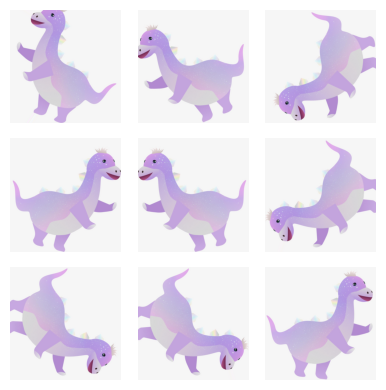

In [13]:
def augment_and_plot(image_path, augmentation_params, num_samples=9):
    # load the image and convert it to a numpy array
    img = load_img(image_path)
    data = img_to_array(img)
    samples = expand_dims(data, 0)
    datagen = ImageDataGenerator(**augmentation_params)
    it = datagen.flow(samples, batch_size=1)

    # generate samples and plot
    fig, axs = pyplot.subplots(3, 3, figsize=(4, 4))
    axs = axs.flatten()
    
    # generate batch of images
    for i in range(num_samples):
        batch = it.next() 
        image = batch[0].astype('uint8')  # convert to unsigned integers for viewing
        axs[i].imshow(image)  
        axs[i].axis('off')  # hide axes for clarity - if you want the axis, you can comment this line out

    pyplot.tight_layout()
    pyplot.show()

# pick a random image from the ones you generated when you were augmenting data
image_path = 'augmented_data/dino/dr_0_12.jpg'
augmentation_params = {'rotation_range': 90, 'horizontal_flip': True}

augment_and_plot(image_path, augmentation_params)


### Model Architecture

We are using a **convolutional neural network (CNN)**, which is ideal for image classification tasks. The model is designed with three convolutional layers and one dense layer for binary classification.

This CNN model is optimised for **binary classification** since we're classifying images into two categories: Barney vs. DurHack Dino. 

The TensorBoard callback is used for real-time monitoring of the model's performance.

In [14]:
def load_data(pickle_files):
    data = []
    for file in pickle_files:
        with open(file, "rb") as f:
            data.append(pickle.load(f))
    return data

pickle_files = ["X.pickle", "y.pickle"]

X, y = load_data(pickle_files)
X = np.array(X)
y = np.array(y)

dense_layers = [0]
layer_sizes = [64]
conv_layers = [3]



In [15]:
## source - https://raihanrnj.medium.com/deep-learning-simple-image-classification-using-convolutional-neural-network-dog-and-cat-8c99aef29e8

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model = Sequential()

            model.add(Conv2D(layer_size, (3, 3), input_shape=X.shape[1:]))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation('relu'))

            model.add(Dense(1))
            model.add(Activation('sigmoid'))

            tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

            model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'],
                          )

            model.fit(X, 
                      y,
                      batch_size=32,
                      epochs=25,
                      validation_split=0.3,
                      callbacks=[tensorboard])

3-conv-64-nodes-0-dense-1730311466


2024-10-30 18:04:26.694911: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/25
61/61 [==============================] - 34s 542ms/step - loss: 10.6438 - accuracy: 0.8398 - val_loss: 8.8015e-05 - val_accuracy: 1.0000
Epoch 2/25
61/61 [==============================] - 33s 540ms/step - loss: 3.2450e-05 - accuracy: 1.0000 - val_loss: 2.0292e-05 - val_accuracy: 1.0000
Epoch 3/25
61/61 [==============================] - 33s 539ms/step - loss: 1.9022e-05 - accuracy: 1.0000 - val_loss: 1.5595e-05 - val_accuracy: 1.0000
Epoch 4/25
61/61 [==============================] - 33s 539ms/step - loss: 1.5379e-05 - accuracy: 1.0000 - val_loss: 1.2715e-05 - val_accuracy: 1.0000
Epoch 5/25
61/61 [==============================] - 33s 536ms/step - loss: 1.2853e-05 - accuracy: 1.0000 - val_loss: 1.0720e-05 - val_accuracy: 1.0000
Epoch 6/25
61/61 [==============================] - 33s 538ms/step - loss: 1.1001e-05 - accuracy: 1.0000 - val_loss: 9.1241e-06 - val_accuracy: 1.0000
Epoch 7/25
61/61 [==============================] - 33s 536ms/step - loss: 9.4551e-06 - accuracy:

Take a look at your model architecture

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 activation (Activation)     (None, 148, 148, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 activation_1 (Activation)   (None, 72, 72, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                   

Our model has **convolutional layers** ```conv2d_12, conv2d_13, conv2d_14```  **activation layers**, ```ReLU```, to help learn complex patterns, **max pooling layers**, ```MaxPooling2D```, to rereduce spatial dimensions to down-sample the feature maps and reduce computational loads, **flatten layers** to flatern the vectors, and a **dense layer** .

So we have a fairly complex model which can capture intricate features. This, alongside a sufficiently large dataset can classify images rather well!

**Helpful Note**: We use **accuracy** as our performance metric, but take a look into some other performance metrics to really be sure your model works well. 

In [17]:
model.save('Dino-Barney-CNN.model')

INFO:tensorflow:Assets written to: Dino-Barney-CNN.model/assets


INFO:tensorflow:Assets written to: Dino-Barney-CNN.model/assets


### Making Predictions

We're now going to test our classification model by testing out whether it's able to correctly classify some newly augmented images!

In [18]:
import cv2
import tensorflow as tf

class_category = ["Dino", "Barney"]
model = tf.keras.models.load_model('Dino-Barney-CNN.model')

In [19]:
IMG_SIZE = 150  # Target image size

class_category = ['Dino', 'Barney']  # Modify this list according to your actual classes

def prepare_image(filepath):
    img_array = cv2.imread(filepath)  # Load the image
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # Resize to expected dimensions
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)  # Reshape for model input


def predict_image(filepath):
    prepared_image = prepare_image(filepath)  # Prepare the image
    prediction = model.predict(prepared_image)  # Get prediction
    img_array = cv2.imread(filepath)  # Read the original image for display
    predicted_class = class_category[int(prediction[0][0] > 0.5)]
    print(f"Prediction: {prediction[0][0]}\nClass: {predicted_class}\n")
    plt.imshow(img_array)
    plt.axis('off')
    plt.show()
    
    return prediction


1/1 [==============================] - 0s 95ms/step
Prediction: 0.9897026419639587
Class: Barney



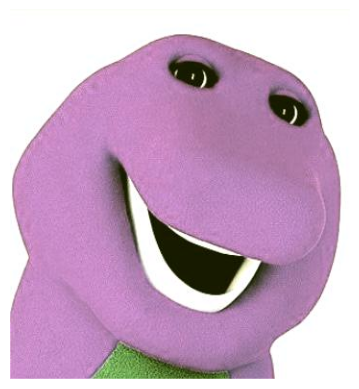

array([[0.98970264]], dtype=float32)

In [20]:
predict_image('Test Images/barney - Copy.jpg')

1/1 [==============================] - 0s 32ms/step
Prediction: 1.2412682508511352e-06
Class: Dino



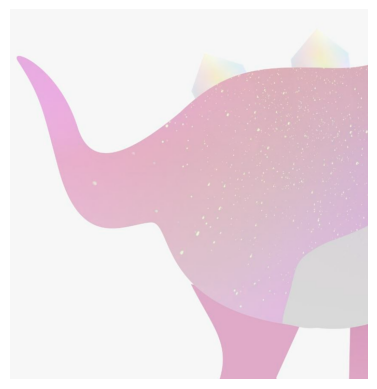

array([[1.2412683e-06]], dtype=float32)

In [21]:
predict_image('Test Images/durhack dino zoomed.JPG')

Nice! You've just built your first image classifier with a CNN!

For further resources, take a look at:
- [3Blue1Brown - But what is a neural network?](https://www.youtube.com/watch?v=aircAruvnKk)
- [Medium: Image Classification using CNN ](https://medium.com/@sssspppp/image-classification-using-cnn-0fad8367acfd)
- [IBM: What are convolutional neural networks?](https://www.ibm.com/topics/convolutional-neural-networks)
